In [1]:
import librosa
import numpy as np
import pandas as pd
from datetime import timedelta
import glob
import natsort
import pandas as pd
import numpy as np
import math
import os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio

# from tensorflow.keras import optimizers
# from keras.callbacks import ReduceLROnPlateau
# from keras.models import Sequential
# from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
# from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Conv2D, MaxPooling2D,BatchNormalization, MaxPooling1D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, ZeroPadding2D
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras import optimizers
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from datetime import timedelta

from keras.callbacks import ModelCheckpoint
# from tensorflow.keras import optimizers
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 


Init Plugin
Init Graph Optimizer
Init Kernel


In [5]:
def visualize(path: str):
    
    # reading the audio file
    raw = wave.open(path)
    Audio(path)  
    # reads all the frames 
    # -1 indicates all or max frames
    signal = raw.readframes(-1)
    signal = np.frombuffer(signal, dtype ="int16")
      
    # gets the frame rate
    f_rate = raw.getframerate()
  
    # to Plot the x-axis in seconds 
    # you need get the frame rate 
    # and divide by size of your signal
    # to create a Time Vector 
    # spaced linearly with the size 
    # of the audio file
    time = np.linspace(
        0, # start
        len(signal) / f_rate,
        num = len(signal)
      
    )
    Audio(path)
   
  
    # using matlplotlib to plot
    # creates a new figure
    plt.figure(1)
      
    # title of the plot
    plt.title(path.split('_')[2])
      
    # label of x-axis
    plt.xlabel("Time")
     
    # actual ploting
    plt.plot(time, signal)
      
    # shows the plot 
    # in new window
    plt.show()
  
    # you can also save
    # the plot using
    # plt.savefig('filename')
  

In [6]:
def createFileList(format='.wav'):
    fileList = []
    #print(/content/Crema)
    for root, dirs, files in os.walk('/Users/omarkhaled/Documents/pr/Crema', topdown=False):
        for name in files:
            if name.endswith(format):
                fullName = os.path.join(root, name)
                fileList.append(fullName)
    return fileList



In [7]:
fileList = createFileList()
Emotions=['HAP','DIS','FEA','NEU','SAD','ANG']
Emotions=np.array(Emotions)
#print(fileList[0].split('_')[0]+'_'+fileList[0].split('_')[1]+'_'+Emotions[0]+'_'+'XX.wav')
for feel in Emotions:
  path=fileList[1500].split('_')[0]+'_'+fileList[0].split('_')[1]+'_'+feel+'_'+'XX.wav'
  #path='1001'+'_'+'DFA'+'_'+feel+'_'+'XX.wav'

  # visualize(path)
 
 
 

In [ ]:
audio = tfio.audio.AudioIOTensor(fileList[0])
audio=audio.to_tensor()
tensor = tf.cast(audio, tf.float32) / 32768.0
print(audio.shape)



(47514, 1)


In [8]:
onehot_encoded_data=[]
for i in fileList:
  onehot_encoded_data.append([i.split('_')[2]])
emotion_df = pd.DataFrame( onehot_encoded_data , columns=['Emotions'] )

# dataframe for path of files.
path_df = pd.DataFrame(fileList, columns=['Path'])
Crema_df = pd.concat([emotion_df, path_df], axis=1)


onehot_encoded_data=np.array(onehot_encoded_data)
encoder = OneHotEncoder(sparse=False)
onehot_encoded_data = encoder.fit_transform(onehot_encoded_data)


Crema_df.head()

,Emotions,Path
0,ANG,/Users/omarkhaled/Documents/pr/Crema/1022_ITS_...
1,ANG,/Users/omarkhaled/Documents/pr/Crema/1037_ITS_...
2,NEU,/Users/omarkhaled/Documents/pr/Crema/1060_ITS_...
3,NEU,/Users/omarkhaled/Documents/pr/Crema/1075_ITS_...
4,DIS,/Users/omarkhaled/Documents/pr/Crema/1073_IOM_...


In [9]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)


    

In [10]:
def shortTermEnergy(frame):
  return sum( [ abs(x)**2 for x in frame ] ) / len(frame)

In [11]:
def zeroCrossingRate(frame):
  signs             = numpy.sign(frame)
  signs[signs == 0] = -1

  return len(numpy.where(numpy.diff(signs))[0])/len(frame)

In [12]:
def ExtractFeatures(soundData,samplingFrequency, frameLength, hopLength):
 zcr = librosa.feature.zero_crossing_rate(y=soundData, frame_length=frameLength,hop_length=hopLength, center=False)
 energy = librosa.feature.rms(y=soundData, center=False, frame_length = frameLength, hop_length=hopLength)
 zcr_col_name = ['Zero_Crossing_Rate']
 energy_col_name = ['Energy']
 column_names = [energy_col_name +zcr_col_name]
 numpy_array_of_features = np.vstack((energy, zcr))
 oneSecondFeatures= pd.DataFrame(numpy_array_of_features.T, columns=column_names)
 return oneSecondFeatures

In [16]:
featuresFile=pd.DataFrame()
for i in range(len(fileList)):
    soundData, samplingFrequency = librosa.load(fileList[i], sr=None)
    oneFileFeatures = ExtractFeatures(soundData,samplingFrequency,frameLength=samplingFrequency, hopLength=samplingFrequency+1)
    featuresFile=featuresFile.append(oneFileFeatures)
    

In [13]:
def extract_features(data,sample_rate):
    #data, sample_rate = librosa.load(fileList)
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally
    
    #short term energy
    result= shortTermEnergy((result,shortTermEnergy(data)))
    
    #spectral centroid
    cent = np.mean(librosa.feature.spectral_centroid(y=data, sr=sample_rate).T,axis = 0)
    result = np.hstack((result, cent))
    
    #spectral bandwidth
    spec_bw = np.mean(librosa.feature.spectral_bandwidth(y=data, sr=sample_rate).T,axis = 0)
    result = np.hstack((result, spec_bw))


    #spectral flattness
    flatness = np.mean(librosa.feature.spectral_flatness(y=data).T,axis=0)
    result = np.hstack((result, flatness))

    return result


In [14]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)



In [15]:
def get_features(path, augment):
    # duration and offset are used to take care of the no audivvo in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path)#, duration=2.5, offset=0.6)
    
    # without augmentation
    res1 = extract_features(data,sample_rate)
 
    result = np.array(res1)
    
    if augment:
        # data with noise
        noise_data = noise(data)
        
        res2 = extract_features(noise_data,sample_rate)
        
        result = np.vstack((result, res2)) # stacking vertically
        
        # data with stretching and pitching
        new_data = stretch(data)
        
        data_stretch_pitch = pitch(new_data, sample_rate)
        
        res3 = extract_features(data_stretch_pitch,sample_rate)
        
        result = np.vstack((result, res3)) # stacking vertically
    
    return result

In [16]:
##function generate mel spectogram for read audio 
def get_mel_wav(data,sr):
  mel_spectrogram = librosa.feature.melspectrogram(data, sr=sr, n_fft=2048, hop_length=512, n_mels=128)
  log_mel_spectrogram = librosa.power_to_db(mel_spectrogram)
  return log_mel_spectrogram

In [17]:
##splitting thDS to test,train,val and specifing batch_size,epochs,num_classes
X1_train, X1_test, y1_train, y1_test = train_test_split( fileList, onehot_encoded_data, test_size=0.3, random_state=42,shuffle='Yes')
X1_trainfinal, X1_vaildate, y1_trainfinal, y1_validate = train_test_split( X1_train, y1_train, test_size=0.05, random_state=42,shuffle='Yes')

batch_size = 128
epochs = 50
num_classes = 6


In [18]:
X_train = X1_trainfinal
y_train = y1_trainfinal

In [ ]:
X, Y = [], []
X_train=np.array(X_train)
i =0
runs =100
for path, emotion in zip(X_train,y_train):
    if i%runs == 0:
        print(i)
    feature = get_features(path,True)
    X.append(feature)
    Y.append(emotion)
    i+=1

In [23]:
X_train_features = np.array(X)
y_train_features = np.array(Y)
new_ytrain = np.copy(y_train_features)
new_ytrain = np.repeat(new_ytrain, 3, axis=0)
y_train_features = new_ytrain
test = np.copy(X_train_features)
# print(test[0])
test = test.reshape(((test.shape[0]*test.shape[1]),test.shape[2]))
X_train_features = test
print(X_train_features.shape,y_train_features.shape)

(14844, 37) (14844, 6)


In [25]:
X_test = X1_test
y_test = y1_test
X_validate = X1_vaildate
y_validate = y1_validate

In [26]:
X2, Y2 = [], []
X_test=np.array(X_test)
for path, emotion in zip(X_test,y_test):
    feature = get_features(path,False)
    X2.append(feature)
    Y2.append(emotion)

In [27]:
X3, Y3 = [], []
X_validate=np.array(X_validate)

for path, emotion in zip(X_validate,y_validate):
    feature = get_features(path,False)
    X3.append(feature)
    Y3.append(emotion)
        
   

In [28]:
X_test_features = np.array(X2)
y_test_features = np.array(Y2)
X_validate_features = np.array(X3)
y_validate_features = np.array(Y3)

In [29]:
X_train_features = X_train_features[:,:,np.newaxis]
# y_train_features = y_train_features[:,:,np.newaxis]
X_test_features  = X_test_features[:,:,np.newaxis]
# y_test_features = y_test_features[:,:,np.newaxis]
X_validate_features = X_validate_features[:,:,np.newaxis]
# y_validate_features = y_validate_features[:,:,np.newaxis]


In [ ]:
print(X_train_features.shape,y_train_features,X_test_features.shape,y_test_features,X_validate_features.shape,y_validate_features)
print(y_train_features[0])

In [31]:
with open('features.npy', 'wb') as f:
    np.save(f, X_train_features)
    np.save(f, y_train_features)

    np.save(f, X_test_features)
    np.save(f, y_test_features)

    np.save(f, X_validate_features)
    np.save(f, y_validate_features)


In [2]:
#reading the data set feom the npy file
import numpy as np
X_train_features = None
y_train_features = None
X_test_features =None
y_test_features = None
X_validate_features = None
y_validate_features = None

with open('features.npy', 'rb') as f:
    X_train_features = np.load(f)
    y_train_features = np.load(f)
    X_test_features = np.load(f)
    y_test_features = np.load(f)
    X_validate_features = np.load(f)
    y_validate_features = np.load(f)


In [13]:
print(X_train_features.shape,y_train_features.shape,X_test_features.shape,y_test_features.shape,X_validate_features.shape,y_validate_features.shape)

(14844, 37, 1) (14844, 6) (2233, 37, 1) (2233, 6) (261, 37, 1) (261, 6)


In [18]:
model=Sequential()


# model.add(Dense(units=512,activation='relu', input_shape=(X_train_features.shape[1], 1),use_bias= True))
# model.add(Dropout(0.2))

# model.add(Dense(units=64,activation='relu' ))
# model.add(Dropout(0.1))

# model.add(Dense(units=512,activation='relu'))
# model.add(Dropout(0.1))

model.add(Conv1D(512, kernel_size=3, strides=2, padding='same', activation='relu', input_shape=(X_train_features.shape[1], 1),use_bias= True))
# model.add(MaxPooling1D(pool_size=3, strides = 2, padding = 'same'))
# model.add(BatchNormalization())

model.add(Conv1D(512, kernel_size=3, strides=2, padding='same', activation='relu',use_bias= True))
# model.add(MaxPooling1D(pool_size=3, strides = 2, padding = 'same'))
# model.add(BatchNormalization())

model.add(Conv1D(128, kernel_size=3, strides=2, padding='same', activation='relu',use_bias= True))
# model.add(MaxPooling1D(pool_size=3, strides = 2, padding = 'same'))
# model.add(BatchNormalization())

model.add(Conv1D(64, kernel_size=3, strides=2, padding='same', activation='relu',use_bias= True))
model.add(Conv1D(64, kernel_size=3, strides=2, padding='same', activation='relu',use_bias= True))
model.add(Conv1D(64, kernel_size=3, strides=2, padding='same', activation='relu',use_bias= True))
model.add(Conv1D(64, kernel_size=3, strides=2, padding='same', activation='relu',use_bias= True))
model.add(Conv1D(64, kernel_size=3, strides=2, padding='same', activation='relu',use_bias= True))
model.add(Conv1D(64, kernel_size=3, strides=2, padding='same', activation='relu',use_bias= True))
model.add(Conv1D(64, kernel_size=3, strides=2, padding='same', activation='relu',use_bias= True))
model.add(Conv1D(64, kernel_size=3, strides=2, padding='same', activation='relu',use_bias= True))
model.add(Conv1D(64, kernel_size=3, strides=2, padding='same', activation='relu',use_bias= True))
# model.add(MaxPooling1D(pool_size=3, strides = 2, padding = 'same'))
# model.add(BatchNormalization())
# model.add(Conv1D(64, kernel_size=3, strides=1, padding='same', activation='relu'))
# model.add(MaxPooling1D(pool_size=3, strides = 2, padding = 'same'))
# # model.add(BatchNormalization())
# model.add(Conv1D(64, kernel_size=3, strides=1, padding='same', activation='relu'))
# model.add(MaxPooling1D(pool_size=3, strides = 2, padding = 'same'))
# # model.add(BatchNormalization())


# model.add(Conv1D(128, kernel_size=3, strides=2, padding='same', activation='relu'))
# model.add(MaxPooling1D(pool_size=3, strides = 2, padding = 'same'))
# model.add(BatchNormalization())
# model.add(Conv1D(32, kernel_size=3, strides=1, padding='same', activation='relu'))
# model.add(MaxPooling1D(pool_size=3, strides = 2, padding = 'same'))
# # model.add(BatchNormalization())
# model.add(Conv1D(32, kernel_size=3, strides=1, padding='same', activation='relu'))
# model.add(MaxPooling1D(pool_size=3, strides = 2, padding = 'same'))
# model.add(BatchNormalization())
# model.add(Conv1D(64, kernel_size=3, strides=2, padding='same', activation='relu'))
# model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
# model.add(BatchNormalization())
# model.add(Conv1D(128, kernel_size=3, strides=3, padding='same', activation='relu'))
# # model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
# model.add(BatchNormalization())

# model.add(Conv1D(64, kernel_size=3, strides=2, padding='same', activation='relu'))
# # model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
# model.add(BatchNormalization())

# model.add(Conv1D(128, kernel_size=3, strides=3, padding='same', activation='relu'))
# # model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
# model.add(BatchNormalization())

# model.add(Conv1D(256, kernel_size=3, strides=2, padding='same', activation='relu'))
# model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
# model.add(BatchNormalization())
model.add(Flatten())
# model.add(Dense(units=512,activation='relu'))

# model.add(Dropout(0.2))

model.add(Dense(units=256, activation='relu',use_bias= True))
# model.add(Dropout(0.3))

model.add(Dense(units=6, activation='softmax'))
# opt = optimizers.Adam(lr=0.001)
opt = optimizers.Adam(
  lr = 0.0001
)

model.compile(optimizer=opt , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_84 (Conv1D)           (None, 19, 512)           2048      
_________________________________________________________________
conv1d_85 (Conv1D)           (None, 10, 512)           786944    
_________________________________________________________________
conv1d_86 (Conv1D)           (None, 5, 128)            196736    
_________________________________________________________________
conv1d_87 (Conv1D)           (None, 3, 64)             24640     
_________________________________________________________________
conv1d_88 (Conv1D)           (None, 2, 64)             12352     
_________________________________________________________________
conv1d_89 (Conv1D)           (None, 1, 64)             12352     
_________________________________________________________________
conv1d_90 (Conv1D)           (None, 1, 64)            

In [19]:
rlrp = ReduceLROnPlateau(monitor='val_loss', factor=0.4, verbose=0, patience=2, min_lr=0.00001,delta = 0.09)
# initial_learning_rate = 0.01
# def lr_step_decay(epoch, lr):
#     drop_rate = 0.1
#     epochs_drop = 10.0
#     return initial_learning_rate * math.pow(drop_rate, math.floor(epoch/epochs_drop))
# # Fit the model to the training data
# history_step_decay = 
# def step_decay(epoch):
# 	initial_lrate = initial_learning_rate
# 	drop = 0.5
# 	epochs_drop = 10.0
# 	lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
# 	return lrate

# history = model.fit(
#     X1_train,
#     y1_train,
#     epochs=epochs,
#     validation_split=0.05,
#     batch_size=batch_size,
#     callbacks=[LearningRateScheduler(lr_step_decay, verbose=2)],
# )

history=model.fit(X_train_features, y_train_features, batch_size=32, epochs=100, validation_data=(X_validate_features, y_validate_features),callbacks=[rlrp])
# , callbacks=[LearningRateScheduler(lr_step_decay, verbose=2)],)
# , callbacks=[LearningRateScheduler(lr_step_decay, verbose=2)])
# , callbacks=[rlrp])

Epoch 1/100
  1/464 [..............................] - ETA: 3:03 - loss: 2.0115 - accuracy: 0.1562

2021-07-12 14:59:11.571598: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


464/464 [==============================] - 7s 15ms/step - loss: 1.7353 - accuracy: 0.2284 - val_loss: 1.5925 - val_accuracy: 0.3640
Epoch 2/100
  5/464 [..............................] - ETA: 7s - loss: 1.6531 - accuracy: 0.3250

2021-07-12 14:59:18.591068: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


464/464 [==============================] - 7s 15ms/step - loss: 1.5882 - accuracy: 0.3267 - val_loss: 1.4983 - val_accuracy: 0.4215
Epoch 3/100
464/464 [==============================] - 7s 15ms/step - loss: 1.5304 - accuracy: 0.3577 - val_loss: 1.4723 - val_accuracy: 0.4023
Epoch 4/100
464/464 [==============================] - 7s 15ms/step - loss: 1.5179 - accuracy: 0.3610 - val_loss: 1.4743 - val_accuracy: 0.4176
Epoch 5/100
464/464 [==============================] - 7s 15ms/step - loss: 1.5039 - accuracy: 0.3718 - val_loss: 1.4845 - val_accuracy: 0.3946
Epoch 6/100
464/464 [==============================] - 7s 15ms/step - loss: 1.4788 - accuracy: 0.3800 - val_loss: 1.4398 - val_accuracy: 0.4138
Epoch 7/100
464/464 [==============================] - 8s 16ms/step - loss: 1.4728 - accuracy: 0.3835 - val_loss: 1.4430 - val_accuracy: 0.3755
Epoch 8/100
464/464 [==============================] - 7s 15ms/step - loss: 1.4694 - accuracy: 0.3847 - val_loss: 1.4231 - val_accuracy: 0.4330
Epoc

In [68]:

history=model.fit(X_train_features, y_train_features, batch_size=256, epochs=100, validation_data=(X_validate_features, y_validate_features))

Epoch 1/100
58/58 [==============================] - 3s 47ms/step - loss: 1.1249 - accuracy: 0.5482 - val_loss: 1.8876 - val_accuracy: 0.3908
Epoch 2/100
58/58 [==============================] - 3s 46ms/step - loss: 1.1161 - accuracy: 0.5527 - val_loss: 1.5707 - val_accuracy: 0.4061
Epoch 3/100
58/58 [==============================] - 3s 46ms/step - loss: 1.1270 - accuracy: 0.5456 - val_loss: 1.5844 - val_accuracy: 0.4330
Epoch 4/100
58/58 [==============================] - 3s 46ms/step - loss: 1.1152 - accuracy: 0.5515 - val_loss: 1.6577 - val_accuracy: 0.4023
Epoch 5/100
58/58 [==============================] - 3s 47ms/step - loss: 1.1191 - accuracy: 0.5482 - val_loss: 1.8629 - val_accuracy: 0.4253
Epoch 6/100
58/58 [==============================] - 3s 46ms/step - loss: 1.0995 - accuracy: 0.5584 - val_loss: 1.7475 - val_accuracy: 0.3755
Epoch 7/100
58/58 [==============================] - 3s 46ms/step - loss: 1.0936 - accuracy: 0.5635 - val_loss: 1.7471 - val_accuracy: 0.4483
Epoch 

In [20]:
test_eval = model.evaluate(X_test_features, y_test_features, verbose=0)
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

Test loss: 1.414217233657837
Test accuracy: 0.430362731218338


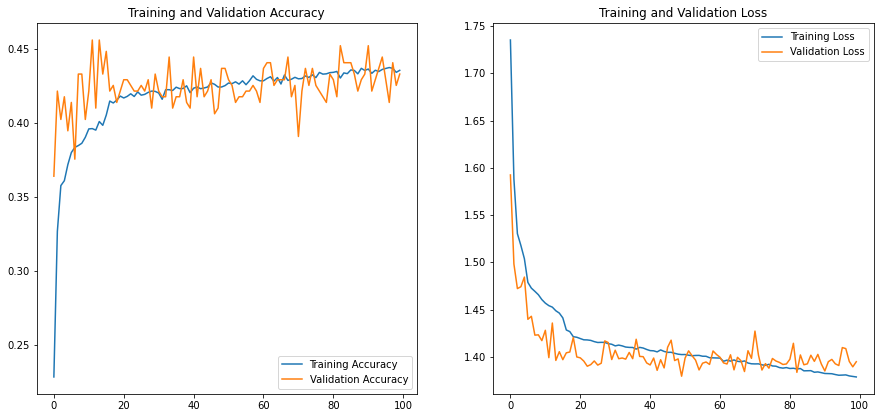

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(100)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()